In [1]:
import sys
import os

sys.path.append('..')

In [2]:
from laion_dataset import LAIONDataset
import matplotlib.pyplot as plt
import random

/gpfs/space/home/zaliznyi/miniconda3/envs/controlnet/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset = LAIONDataset()

Parsing directory 00000...


In [9]:
print(len(dataset))

idx = random.randint(0, len(dataset) - 1)

item = dataset[idx]
jpg = item['jpg']
txt = item['txt']
hint = item['hint']
print(txt)
print(jpg.shape)
print(hint.shape)

257499


error: OpenCV(4.3.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
plt.imshow(jpg)

In [ ]:
plt.imshow(hint)

In [4]:
from share import *
import config

import cv2
import einops
import numpy as np
import torch
import random
import imageio as iio
import matplotlib.pyplot as plt

from pytorch_lightning import seed_everything
from annotator.util import resize_image, HWC3
from annotator.canny import CannyDetector
from cldm.model import create_model, load_state_dict
from cldm.ddim_hacked import DDIMSampler

/gpfs/space/home/zaliznyi/miniconda3/envs/controlnet/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


logging improved.


In [5]:
ROOT = "/gpfs/space/projects/stud_ml_22/ControlNet-different-backbones/"

In [6]:
import torch
torch.cuda.is_available()

True

In [7]:
apply_canny = CannyDetector()

model = create_model(os.path.join(ROOT, './models/cldm_lite.yaml')).cpu()
model.load_state_dict(load_state_dict(os.path.join(ROOT, './models/control_lite_conv_ini.ckpt'), location='cuda'))
model = model.cuda()
ddim_sampler = DDIMSampler(model)

No module 'xformers'. Proceeding without it.
ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loaded model config from [/gpfs/space/projects/stud_ml_22/ControlNet-different-backbones/./models/cldm_lite.yaml]
Loaded state_dict from [/gpfs/space/projects/stud_ml_22/ControlNet-different-backbones/./models/control_lite_conv_ini.ckpt]


In [8]:
def process(input_image, prompt, a_prompt='best quality, extremely detailed', n_prompt='longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality', num_samples=3, image_resolution=256, ddim_steps=20, guess_mode=False, strength=1, scale=9., seed=23, eta=0., low_threshold=100, high_threshold=200):
    with torch.no_grad():
        img = resize_image(HWC3(input_image), image_resolution)
        H, W, C = img.shape

        detected_map = apply_canny(img, low_threshold, high_threshold)
        detected_map = HWC3(detected_map)

        control = torch.from_numpy(detected_map.copy()).float().cuda() / 255.0
        control = torch.stack([control for _ in range(num_samples)], dim=0)
        control = einops.rearrange(control, 'b h w c -> b c h w').clone()

        if seed == -1:
            seed = random.randint(0, 65535)
        seed_everything(seed)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        cond = {"c_concat": [control], "c_crossattn": [model.get_learned_conditioning([prompt + ', ' + a_prompt] * num_samples)]}
        un_cond = {"c_concat": None if guess_mode else [control], "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)]}
        shape = (4, H // 8, W // 8)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=True)

        model.control_scales = [strength * (0.825 ** float(12 - i)) for i in range(13)] if guess_mode else ([strength] * 13)  # Magic number. IDK why. Perhaps because 0.825**12<0.01 but 0.826**12>0.01
        samples, intermediates = ddim_sampler.sample(ddim_steps, num_samples,
                                                     shape, cond, verbose=False, eta=eta,
                                                     unconditional_guidance_scale=scale,
                                                     unconditional_conditioning=un_cond)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        x_samples = model.decode_first_stage(samples)
        x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)

        results = [x_samples[i] for i in range(num_samples)]
    return [255 - detected_map] + results

In [14]:
#inp_img = iio.imread('../test_imgs/pose2.png').astype(np.uint8)
#inp_img = iio.imread('/gpfs/space/projects/stud_ml_22/ControlNet-different-backbones/data/fill50k/source/14961.png').astype(np.uint8)
inp_img = iio.imread('/gpfs/space/projects/stud_ml_22/ControlNet-different-backbones/data/laion-art/00000/000000057.jpg').astype(np.uint8)

In [15]:
print(iio.imread('../test_imgs/cute_robot.png').astype(np.uint8).shape)
print(inp_img.shape)

(736, 736, 4)
(288, 512, 3)


In [11]:
inp_img = resize_image(inp_img, 620)

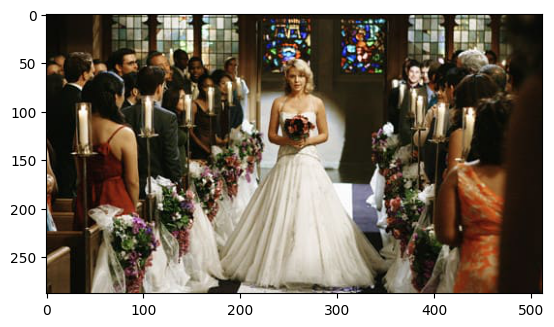

In [16]:
plt.imshow(inp_img)

In [17]:
res = process(
    inp_img, "snow circle with turquoise background", 
    a_prompt="depressed, sadness, gloomy", n_prompt="ugly, blurred",
    num_samples=12, seed=45
)

Global seed set to 45


Data shape for DDIM sampling is (12, 4, 32, 32), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:13<00:00,  1.52it/s]


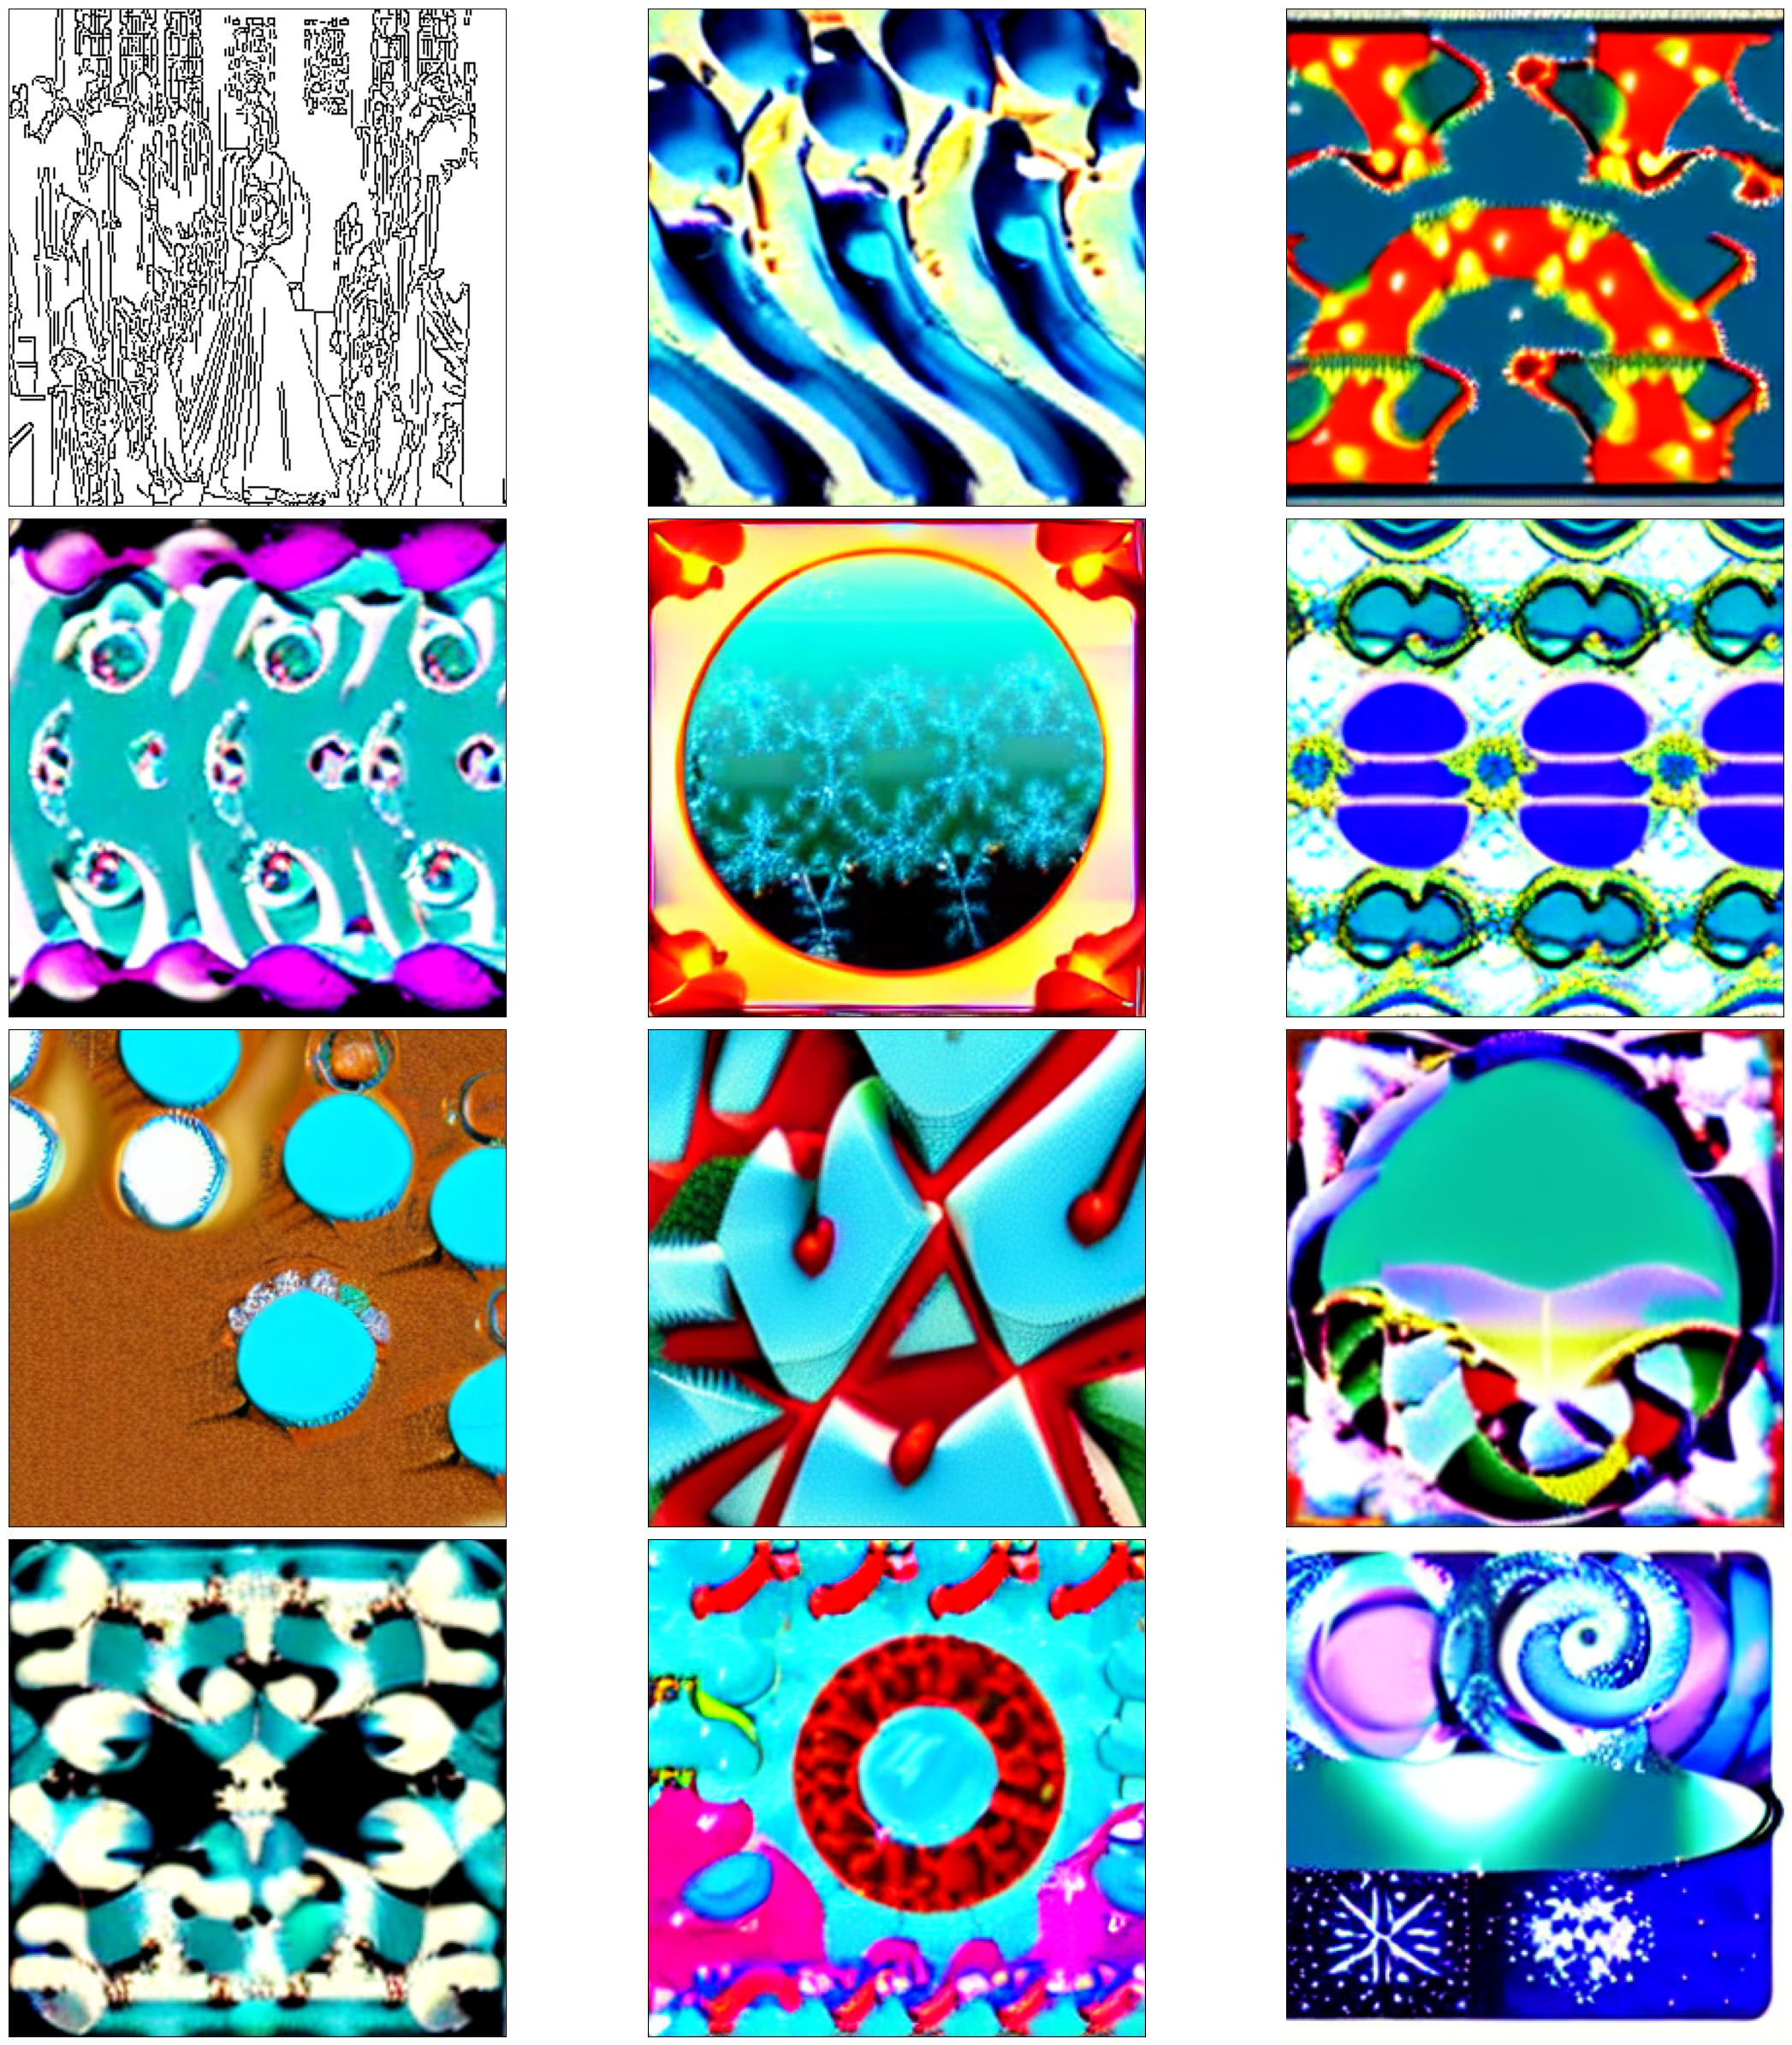

In [18]:
n_row = 4
n_col = 3

fig, axs = plt.subplots(n_row, n_col, figsize=(24, 24))

plt.axis('off')
axs = axs.flatten()

for img, ax in zip(res, axs):
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_xticks([], minor=True)
    ax.set_yticks([])
    ax.set_yticks([], minor=True)

fig.tight_layout()
plt.show()